In [2]:
import pandas as pd
from xml.etree import ElementTree
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import layers
from keras import models
from collections import Counter
from math import ceil, floor
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras.layers import Dropout, Conv3D, BatchNormalization, MaxPooling3D, AveragePooling2D, Activation
import os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from openpyxl import load_workbook
import seaborn as sns

In [3]:
cat_dict = {'acetone':0, 'acetonitrile': 1, 'chloroform':2, 'dichloromethane':3,'diethylether':4,'ethanol':5,'ethylacetate':6,'heptane':7,'hexane':8,'methanol':9,'toluene':10}
cat_dict_reverse = dict(map(reversed,cat_dict.items()))

# GENERATORS


In [3]:
no_files = 0
for i in os.listdir('sequences/train'):
    no_files+=1
    
def batch_generator_from_memory(batch_size = 100, no_training_files=no_files):
    indices = np.arange(no_training_files)
    X = list()
    Y = list()
    while True:
        np.random.shuffle(indices)
        for i in indices:
            aux = np.load('sequences/train/seq_'+str(i)+'.npy', allow_pickle = True)
            X.append(aux[0]/255)
            Y.append(aux[1])
            if len(X)==batch_size:
                yield np.asarray(X), np.asarray(Y)
                X = list()
                Y = list()

In [4]:
no_val_files = 0
for i in os.listdir('sequences/val'):
    no_val_files+=1

def validation_generator(batch_size = 1, no_training_files=no_val_files):
    indices = np.arange(no_training_files)
    X = list()
    Y = list()
    while True:
        for i in indices:
            aux = np.load('sequences/val/seq_'+str(i)+'.npy', allow_pickle = True)
            X.append(aux[0]/255)
            Y.append(aux[1])
            if len(X)==batch_size:
                yield np.asarray(X), np.asarray(Y)
                X = list()
                Y = list()

In [5]:
#CONVOLUTION 3D dimension always ten
def lenet_model_custom(channels, filters_width, dropout_rate, dense_length):
    model = models.Sequential()
    #model.add(Conv3D(channels[0], (filters_width[0], filters_width[0], filters_width[0]), input_shape=(32,148, 148, 3)))
    model.add(Conv3D(channels[0], (10, filters_width[0], filters_width[0]), input_shape=(32,148, 148, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))   
    model.add(MaxPooling3D((2, 2, 2), strides = 2))
    #model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
    model.add(Dropout(dropout_rate))
    #model.add(Conv3D(channels[1], (filters_width[1], filters_width[1], filters_width[1])))
    model.add(Conv3D(channels[1], (10, filters_width[1], filters_width[1])))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling3D((2, 2, 2), strides = 2))
    #model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_length))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(layers.Dense(11, activation='softmax'))
    
    model.summary()
    return model

In [6]:
#GRID SEARCH
channels = [(16,32),(32,64),(64,128)]
filters_width = [(10,10),(15,15),(20,20)]
dropout = [0.2,0.35,0.5]



params = list()
for c in channels:
    for fw in filters_width:
        #flatten_length = floor((floor((39-fw[0]+1)/2)-fw[1]+1)/2) 
        #flatten_length *= flatten_length * c[1]
        #flatten_length *= floor((floor((26-fw[0]+1)/2)-fw[1]+1)/2) 
        #print(flatten_length)
        #dl = floor(flatten_length /2)
        for d in dropout:
            #params.append([c,fw,d,dl])
            #params.append([c,fw,d,floor(dl/2)])
            params.append([c,fw,d,32])
            #params.append([c,fw,d,32])

In [7]:
params[15]

[(32, 64), (20, 20), 0.2, 32]

In [8]:
#Callbacks


batch_size = 10
num_samples = no_files
counter = 15

for i in range(15, 16):
    model = lenet_model_custom(params[i][0],params[i][1],params[i][2],params[i][3])
    save_folder = './logs_3D/lenet_custom_'+ str(counter)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    csv = CSVLogger(save_folder +'/training.log')
    tb = TensorBoard(update_freq='epoch', log_dir = save_folder)
    weigths_name="best_weights.h5"
    mc = ModelCheckpoint(save_folder+'/'+weigths_name, monitor='val_loss', mode='min', save_best_only=True)
    cbs = [mc, es, tb, csv]
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #history = model.fit_generator(batch_generator_from_memory(batch_size = batch_size), 
              #steps_per_epoch = ceil(num_samples / batch_size), epochs = 1000, validation_data = (val_sequences,val_cat),
              #callbacks = cbs)
    history = model.fit_generator(batch_generator_from_memory(batch_size = batch_size), 
              steps_per_epoch = ceil(num_samples / batch_size), epochs = 1000, validation_data = validation_generator(), validation_steps = no_val_files, 
              callbacks = cbs)
    counter += 1

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 23, 129, 129, 32)  384032    
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 129, 129, 32)  128       
_________________________________________________________________
activation_1 (Activation)    (None, 23, 129, 129, 32)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 11, 64, 64, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 64, 64, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)    

# RUN BEST MODEL WITH MORE CHANNELS

# EVALUATE MODELS

In [4]:
loss_acc_dic = {}


for folder in sorted(os.listdir('logs_3D')):
    print(folder)
    correct_counter = 0
    aux = pd.read_csv('logs_3D/'+folder+'/training.log')
    row = aux.loc[aux['val_loss'].idxmin()]
    loss_acc_dic[folder] = {}
    loss_acc_dic[folder]['min_loss'] = row['val_loss']
    loss_acc_dic[folder]['val_acc'] = row['val_acc']
    

acc_weights_lenet_custom_0
acc_weights_lenet_custom_1
acc_weights_lenet_custom_2
acc_weights_lenet_custom_3
acc_weights_lenet_custom_4
acc_weights_lenet_custom_5
acc_weights_lenet_custom_6
acc_weights_lenet_custom_8
balanced_lenet_custom_6
lenet_custom_0
lenet_custom_1
lenet_custom_2
lenet_custom_3
lenet_custom_4
lenet_custom_5
lenet_custom_6
lenet_custom_7
lenet_custom_8


In [5]:
loss_acc_dic

{'acc_weights_lenet_custom_0': {'min_loss': 0.194561110122846,
  'val_acc': 0.9342105263157896},
 'acc_weights_lenet_custom_1': {'min_loss': 0.2736872172458017,
  'val_acc': 0.8954678362573101},
 'acc_weights_lenet_custom_2': {'min_loss': 0.3178550303317035,
  'val_acc': 0.8757309941520468},
 'acc_weights_lenet_custom_3': {'min_loss': 0.3677951591082613,
  'val_acc': 0.9035087719298246},
 'acc_weights_lenet_custom_4': {'min_loss': 0.3928369422325903,
  'val_acc': 0.8625730994152047},
 'acc_weights_lenet_custom_5': {'min_loss': 0.2097952413028316,
  'val_acc': 0.91593567251462},
 'acc_weights_lenet_custom_6': {'min_loss': 0.5307684272204701,
  'val_acc': 0.827485380116959},
 'acc_weights_lenet_custom_8': {'min_loss': 0.6167838642266796,
  'val_acc': 0.8150584795321637},
 'balanced_lenet_custom_6': {'min_loss': 0.26587861660874024,
  'val_acc': 0.9071637426900584},
 'lenet_custom_0': {'min_loss': 0.17425635929695696,
  'val_acc': 0.9371345029239766},
 'lenet_custom_1': {'min_loss': 0.273

In [6]:
min_loss = 10000
for key in loss_acc_dic:
    if(loss_acc_dic[key]['min_loss'] < min_loss):
        min_loss = loss_acc_dic[key]['min_loss']
        best_model = key

In [7]:
best_model

'lenet_custom_2'

# CHECK ACCURACIES PER CLASS

In [8]:
y_pred = {}
y_real = {}

for folder in sorted(os.listdir('logs_3D')):
    if ('acc' not in folder) and ('balanced' not in folder):
        print(folder)
        y_pred[folder] = list()
        y_real[folder] = list()
        model = models.load_model('logs_3D/'+folder+'/best_weights.h5')
        for file in os.listdir('sequences/val'):
            aux = np.load('sequences/val/'+file, allow_pickle = True)
            x = aux[0]/255
            y_real[folder].append(np.argmax(aux[1]))
            y_pred[folder].append(np.argmax(model.predict((x.reshape((1,32,148,148,3))))[0]))
        

lenet_custom_0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
lenet_custom_1
lenet_custom_2
lenet_custom_3
lenet_custom_4
lenet_custom_5
lenet_custom_6
lenet_custom_7
lenet_custom_8


In [9]:
y_real = y_real['lenet_custom_0']

In [4]:
#aux = (y_real, y_pred)
#np.save('val_sequence_predictions_CNN3D.npy',aux)

aux = np.load('val_sequence_predictions_CNN3D.npy', allow_pickle = True)
y_real = aux[0]
y_pred = aux[1]

In [13]:
#CLASSIFICATION REPORT PER MODEL (PRECISIONS, ACCURACIES, F1-SCORES, RECALLS)

reports = {}

cats = list()
for key in cat_dict:
    cats.append(key)

for mod in y_pred:
    reports[mod] = classification_report(y_real, y_pred[mod], target_names=cats, output_dict=True)

In [14]:
#CONFUSION MATRICES
conf_matrices = {}

for mod in y_pred:
    conf_matrices[mod] = confusion_matrix(y_real, y_pred[mod])

In [17]:
###DONT RUN AGAIN#####
wb = load_workbook(filename='CNN3D_results.xlsx')
ws = wb.worksheets[0]

init_col = 5
init_row = 5
cur_col = init_col
cur_row = init_row

for mod in reports:
    ws.cell(row=cur_row, column = cur_col).value = mod
    cur_col += 1
    for key in cat_dict:
        for metric in ['precision', 'recall', 'f1-score']:
            ws.cell(row=cur_row, column = cur_col).value = reports[mod][key][metric]
            cur_col += 1
    
    cur_col += 1
    ws.cell(row=cur_row, column = cur_col).value = reports[mod]['accuracy']
    cur_col += 1
    ws.cell(row=cur_row, column = cur_col).value = reports[mod]['macro avg']['f1-score']
    
    
    cur_col = init_col
    cur_row += 1
    
wb.save('CNN3D_results.xlsx')

In [18]:
cats = []
for key in cat_dict:
    cats.append(key)

Text(0.5, 69.0, 'Predicted Class')

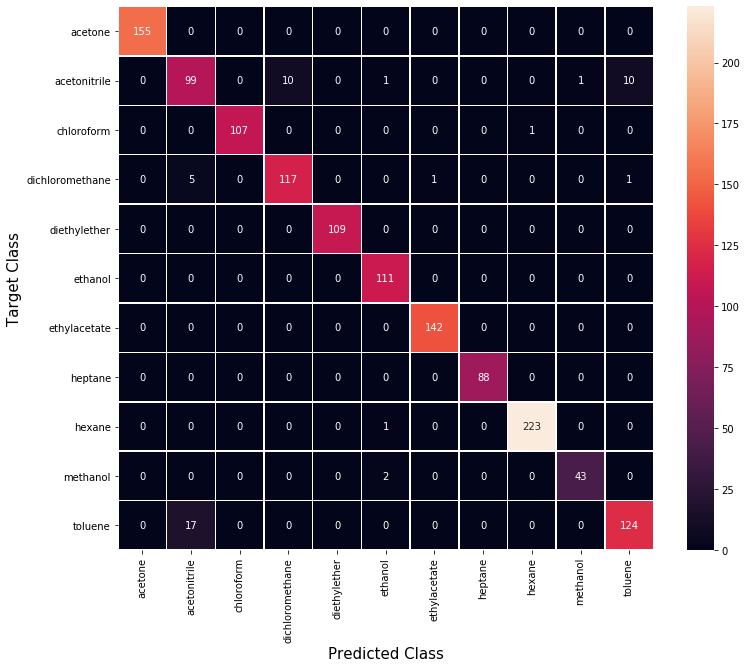

In [22]:
#MODEL HITH HIGHEST F1-SCORE
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_matrices['lenet_custom_6'], annot=True, fmt="d", linewidths=.5, xticklabels = cats, yticklabels = cats)
ax.set_ylabel('Target Class', fontsize = 15)
ax.set_xlabel('Predicted Class', fontsize = 15)